# Geometric shape dataset generator

This notebook generates a geometric shape dataset with structurally defined parameters variations according to issue. This builds upon the generate_geometric_shapes notebook. 

In [23]:
import io
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from scipy.stats import norm

np.random.seed(0)

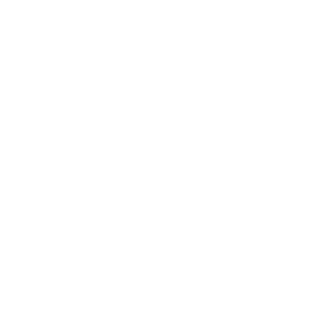

In [24]:
# Size of canvas
image_width = 64
image_height = 64
super_sampling_scale = 7
width = super_sampling_scale * image_width
height = super_sampling_scale * image_height

# Actual value of DPI does not matter for final output
# Larger value makes the matplotlib canvas smaller on screen
dpi = 100

# create a figure with fixed size
fig = plt.figure(frameon=False)
fig.set_size_inches(width/dpi, height/dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)

ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.patch.set_facecolor('blue')

io_buf = io.BytesIO()

In [25]:
def draw_shape(shape, x=.5*width, y=.5*height, bg_color=1, **kwargs):
    """
    Draw a shape on the matplotlib figure and return it as numpy array
    """
    # set background colour by adding a square patch
    bg_patch = ax.add_patch(patches.Rectangle((0, 0), width, height, color=str(bg_color)))
    if shape == 'circle':
        patch = generate_circle(x, y, **kwargs)
    elif shape == 'triangle':
        patch = generate_triangle(x, y, **kwargs)
    else:
        raise ValueError(f"Invalid shape: {shape}")
    # keep reference to the patch connected to the axis so it can be removed later
    patch = ax.add_patch(patch)
    # extract data from image
    # taken from https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
    io_buf.seek(0)
    fig.savefig(io_buf, format='rgba', dpi=dpi)
    io_buf.seek(0)
    # load (flattened) image into numpy array, reshape, keep only one channel (R)
    img = np.frombuffer(io_buf.getvalue(), dtype=np.uint8).reshape(width, height, -1)[..., 0]

    # remove the patches from the axis
    patch.remove()
    bg_patch.remove()
    return img

def generate_circle(x, y, radius, color):
    """
    Generate a matplotlib circle patch
    """
    return patches.Circle((x, y), radius, fc=str(color), ec=None)

def generate_triangle(x, y, radius, angle, color):
    """
    Generate a matplotlib triangle patch
    """
    a = rot(angle).dot(np.array([0, radius]))
    b = rot(120).dot(a)
    c = rot(120).dot(b)
    m = np.array([x,y])
    return patches.Polygon([a+m, b+m, c+m], fc=str(color), ec=None, closed=True)
    
def rot(angle_deg):
    """
    2D rotation matrix for given angle in degrees
    """
    angle = np.deg2rad(angle_deg)
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

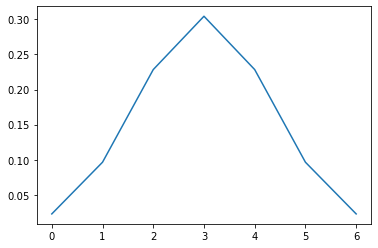

In [26]:
def get_smoothing_kernel(super_sampling_scale):
    """
    Gaussian smoothing kernel for given super-sampling scale
    """
    a = np.arange(super_sampling_scale).astype(float)
    a -= a.mean()
    a /= 0.66*a.std() 
    d = norm.pdf(a)
    d /= d.sum()
    return d

plt.plot(get_smoothing_kernel(7))

In [27]:
def uniform_complements(contrast: float) -> tuple():
    """
    Generate uniformly random numbers within range [0, 1] that sum to parameter contrast. 
    Contrast is also in [0, 1] range. 
    """
    assert 0 <= contrast and 1 >= contrast 

    # Choose at random the biggest random number
    if np.random.rand() < 0.5:
        rand1 = np.random.uniform(0, 1 - contrast)
        rand2 = rand1 + contrast
    else:
        rand1 = np.random.uniform(contrast, 1)
        rand2 = rand1 - contrast
        
    return rand1, rand2


def generate_grid(param_variations, contrast_idx=-1):
    """
    Generate a grid for all possible parameter combinations given param_variations.
    Generates random fore- and background colors for the parameter variations at index contrast_idx
    """
    grid = np.array(np.meshgrid(*param_variations, indexing='ij')).T.reshape(-1, len(param_variations)) # Get param combinations
    
    # Retrieve colors and stack to single grid
    vuniform_complements = np.vectorize(uniform_complements)
    contrasts = grid[:,contrast_idx]
    colors = np.stack(vuniform_complements(contrasts), axis = -1)
    return np.hstack((grid, colors))

In [28]:
# Generate the circles and triangles
# Generate all possible combinations of #nvariations parameters
nvariations = 10
ncircle = nvariations ** 2
ntriangle = nvariations ** 3
radius_range = (.2*min(width, height), .48*min(width, height))

shapes = np.empty(shape=(ncircle+ntriangle, height, width))

# circles 
radii = np.sort(np.random.uniform(*radius_range, nvariations))
contrasts = np.sort(np.random.uniform(0, 1, nvariations))
circle_params = generate_grid((radii, contrasts))
for n, params in tqdm.tqdm(enumerate(circle_params)):
    shapes[n] = draw_shape('circle', radius=params[0], color=params[2], bg_color=params[3])

# triangles
radii = np.sort(np.random.uniform(*radius_range, nvariations))
angles = np.sort(np.random.uniform(0, 360, nvariations))
contrasts = np.sort(np.random.uniform(0, 1, nvariations))
triangle_params = generate_grid((radii, angles, contrasts))
for n, params in tqdm.tqdm(enumerate(triangle_params)):
    shapes[ncircle + n] = draw_shape('triangle', radius=params[0], angle=params[1], color=params[3], bg_color=params[4])    

100it [00:00, 251.48it/s]
1000it [00:02, 337.88it/s]


In [29]:
# scale to 0-1 (memory and compute intensive step)
shapes = shapes.astype(float) / 255.

shapes.dtype

dtype('float64')

1100it [00:01, 860.73it/s]

(1100, 448, 448)
(1100, 64, 64)


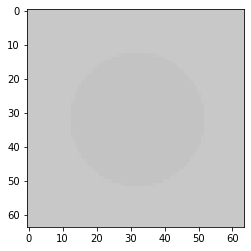

In [30]:
# apply Gaussian blur ONLY APPLY THIS ONCE

for i,_ in tqdm.tqdm(enumerate(shapes)):
    shapes[i] = cv2.GaussianBlur(shapes[i], (super_sampling_scale, super_sampling_scale), 0.3*super_sampling_scale,0)

# Extract subset of smoothed data to obtain target image size
print(shapes.shape)
shapes = shapes[:,::super_sampling_scale,::super_sampling_scale] # NB! This causes the circle to shift by less than 1 pixel, but the result is not exactly centered.
print(shapes.shape)
plt.imshow(shapes[0], cmap='gray', vmin=0, vmax=1)

In [31]:
# Save our data to npz 

circles = shapes[:ncircle]
triangles = shapes[ncircle:]

circle_param_names = ['radius', 'contrast', 'foreground_color', 'background_color']
triangle_param_names = ['radius', 'angle', 'contrast', 'foreground_color', 'background_color']

np.savez_compressed('shapes.npz', circles=circles, triangles=triangles, circle_params=circle_params, 
                    triangle_params=triangle_params, circle_param_names=circle_param_names,
                    triangle_param_names=triangle_param_names)

In [32]:
!du -hs shapes.npz

1.5M	shapes.npz


In [33]:
# load data from disk
fd = np.load('shapes.npz')
circles = fd['circles']
circle_params = fd['circle_params']


triangles = fd['triangles']
triangle_params = fd['triangle_params']
fd.close()

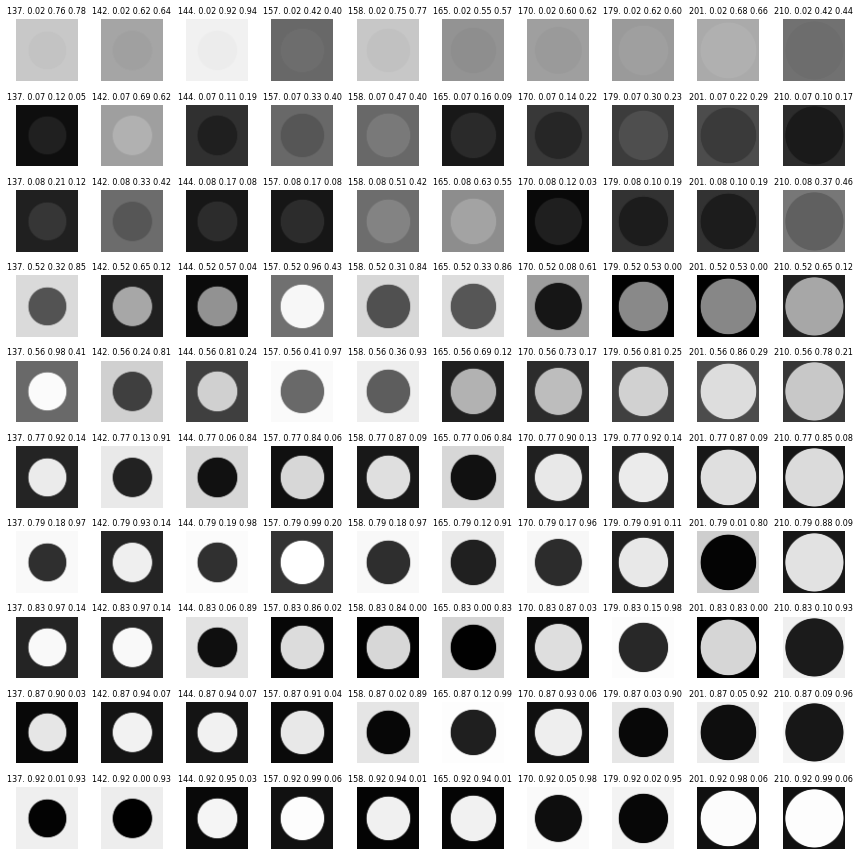

In [34]:
# Overview of the generated circles with parameters (radius, contrast, fg_color, bg_color)
overview_fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(12, 12))
axes = axes.flatten()

for i in range(100):
    a = axes[i]
    a.imshow(circles[i], cmap='gray', vmin=0, vmax=1)
    a.set_title(" ".join([str(p)[:4] for p in circle_params[i]]), fontsize=8)
    a.axis('off')
    
overview_fig.tight_layout()

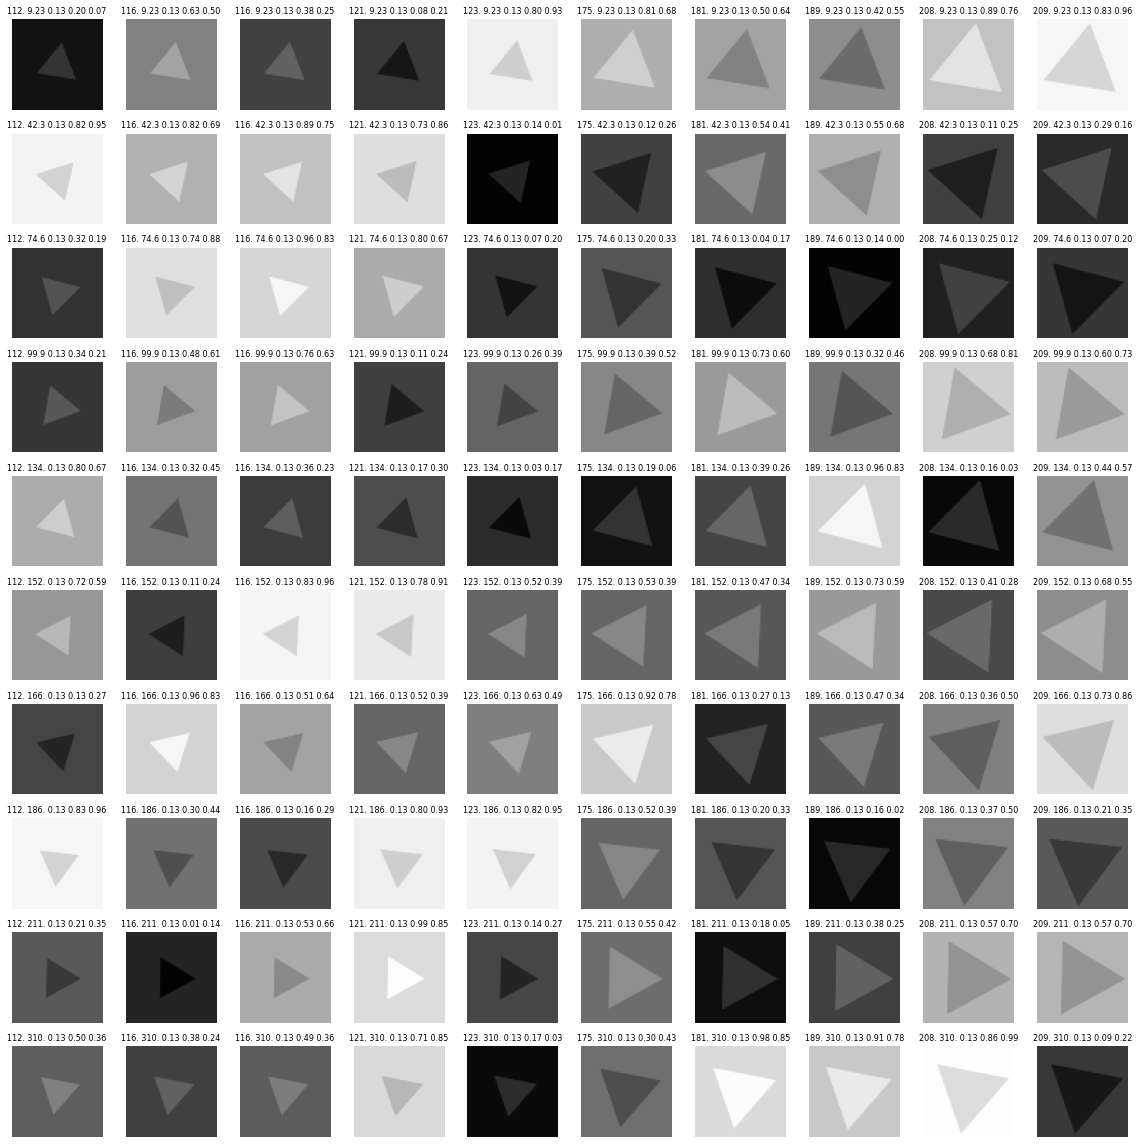

In [35]:
# Overview of the generated triangles with parameters (radius, angle, contrast, fg_color, bg_color)
overview_fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(16, 16))
axes = axes.flatten()

for i in range(100):
    a = axes[i]
    a.imshow(triangles[i], cmap='gray', vmin=0, vmax=1)
    a.set_title(" ".join([str(p)[:4] for p in triangle_params[i]]), fontsize=8)
    a.axis('off')
    
overview_fig.tight_layout()